In [1]:
using LinearAlgebra, JuMP, CPLEX, Plots, Distributions, Printf, JLD2

# Computing State-space Model from transfer function

$$ y(s) = \dfrac{1}{125s^3 + 75s^2 + 15s + 1} \ u(s) $$

State-space representation from the transfer function above (from matlab):

In [2]:
A_drto = [2.45619225923395 -2.01096013810692 0.548811636094027; 
    1 0 0;
    0 1 0]
# uncertainty in B matrix
# B_drto = [0.0625; 0; 0]
C_drto = [0.0183756999177941, 0.0633113580621751, 0.0136128264831647];

System configuration

In [3]:
# Sampling time
T = 1
# Number of manipulated inputs
nu = 1
# Number of controlled outputs
ny = 1
# Number of states
nx = 3;

Controller configuration

In [4]:
# Output prediction horizon
p = 30
# Input control horizon 
m = 3
# Output weights
q = 1
# Input weights aggressive = 1 | detuned = 20
r = 1;

DRTO configuration

In [5]:
# Prediction horizon 30 | 50
pD = 50
# Input control horizon 
mD = 20;

Setting parameters for matrices for DRTO (Open and Closed-loop)

In [6]:
# setting initial values
x0 = [0.0;0.0;0.0]
y0 = C_drto'*[0.0;0.0;0.0]
u0 = 0.0;

# setting bounds 
ΔUMax = 0.3
uMax = 1.2
uMin = 0.0
yMax = 1.5
yMin = 0.0;

# Solving OL-DRTO Multiscenario Problem (nondecomposed)

In [7]:
#number os scenarios
nScen = 3

#DRTO execution period
nDRTO = 5

#equiprobable scenarios
pScen = 1.0/nScen;

# uncertainty in B - each column represent a different realization
B_drto_s = [0.05 0.0625 0.07; 0 0 0; 0 0 0];

In [8]:
## Modeling the sub problem (scenario) -- modeling inside a function
function MS_OLDRTO(xInit,uInit)

    # Define our model
    model_ms = Model(CPLEX.Optimizer)
    #set_optimizer_attribute(model_ms, "CPXPARAM_ScreenOutput"=false)
    # set_optimizer_attribute(m, "warm_start_init_point", "yes")

    # Set up variables
    # inputs computed by MPCs
    @variable(model_ms, uMin <= u[1:pD,1:nScen] <= uMax)
    # initial states used by MPC for computing the optimal trajectory
    @variable(model_ms, x[1:pD, 1:nx,1:nScen])
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(model_ms, yMin <= y[1:pD,1:nScen] <= yMax)
    # slacks for controlling setpoint into a zone
    @variable(model_ms, delta_y_p[1:pD,1:nScen] >= 0)
    @variable(model_ms, delta_y_m[1:pD,1:nScen] >= 0)

    # Set up objective function
    @objective(model_ms, Min, pScen*sum(u[kk,ss] + 1e5*(delta_y_p[kk,ss]^2 + delta_y_m[kk,ss]^2) 
            for kk in 1:pD, ss in 1:nScen))

    # Model Dynamic for Dynamic RTO
    @constraint(model_ms, OLDRTO_dyn_model_1[ss=1:nScen], x[1,:,ss] .== A_drto*xInit + B_drto_s[:,ss]*uInit)
    @constraint(model_ms, OLDRTO_dyn_model[kk=1:(pD - 1),ss=1:nScen], x[kk + 1,:,ss] .== A_drto*x[kk,:,ss] + B_drto_s[:,ss]*u[kk,ss])
    @constraint(model_ms, OLDRTO_model_out[kk=1:pD,ss=1:nScen], y[kk,ss] == C_drto'*x[kk,:,ss])

    # fixing input after mD
    @constraint(model_ms, control_horizon[kk=(mD+1):pD,ss=1:nScen], u[kk,ss] == u[mD,ss])

    # Δu constraints
    @constraint(model_ms, ΔU_max_0[ss=1:nScen], -ΔUMax <= u[1,ss] - uInit <= ΔUMax)
    @constraint(model_ms, ΔU[kk=2:mD,ss=1:nScen], -ΔUMax <= u[kk,ss] - u[kk - 1,ss] <= ΔUMax)

    # ysp in target
    @constraint(model_ms, target_plus[kk=1:pD,ss=1:nScen], y[kk,ss] + delta_y_p[kk,ss] >= 0.95)
    @constraint(model_ms, target_minus[kk=1:pD,ss=1:nScen], y[kk,ss] - delta_y_m[kk,ss] <= 1.05)

    # nonanticipativity constraints
    @constraint(model_ms, nonAnt[kk=1:nDRTO,ss=2:nScen], u[kk,1] - u[kk,ss] == 0.0);
    
    # @show model_ms
    
    optimize!(model_ms)
    flag = termination_status(model_ms)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(model_ms)
    uArray = value.(u)
    xArray = value.(x)
    yArray = value.(y)
    dpArray = value.(delta_y_p)
    dmArray = value.(delta_y_m)
    
    # all_con = all_constraints(model_ms, AffExpr, MOI.EqualTo{Float64})
    λ = dual.(nonAnt)
    
    return Dict('o' => o, 'f' => flag, 'λ' => λ, 'u' => uArray, 'x' => xArray, 'y' => yArray, 'd' => dpArray, 'c' => dmArray)
end;

In [9]:
# Solve the model
solDict = MS_OLDRTO(x0,u0);
display(solDict['o'])

CPLEX Error  3003: Not a mixed-integer problem.
Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
Tried aggregator 1 time.
QP Presolve eliminated 44 rows and 45 columns.
Aggregator did 412 substitutions.
Reduced QP has 604 rows, 653 columns, and 1949 nonzeros.
Reduced QP objective Q matrix has 285 nonzeros.
Presolve time = 0.00 sec. (0.88 ticks)
Parallel mode: using up to 16 threads for barrier.

***NOTE: Found 3 dense columns.

Number of nonzeros in lower triangle of A*A' = 2418
Using Approximate Minimum Degree ordering
Total time for automatic ordering = 0.00 sec. (0.20 ticks)
Summary statistics for Cholesky factor:
  Threads                   = 16
  Rows in Factor            = 607
  Integer space required    = 970
  Total non-zeros in factor = 5143
  Total FP ops to factor    = 72153
 Itn      Primal Obj        Dual Obj  Prim Inf Upper Inf  Dual Inf          
   0   9.5706092e+06  -9.6930592e+06  1.95e+02  1.87e+02  1.90e+07
   1   4.8090587e+06  -4.7611044e+06  1.34e+02  1.28e+

986403.5681285725

In [10]:
# time series for plotting
ts = Vector{Float64}(undef,pD) 
for i in 1:pD
    ts[i] = 1*i
end

# Get values for plotting
xTraj_m_ol = Array{Float64}(undef,nx,pD,nScen)
uTraj_m_ol = Matrix{Float64}(undef,pD,nScen) 
yTraj_m_ol = Matrix{Float64}(undef,pD,nScen) 

for i in 1:pD
    for s in 1:nScen
        xTraj_m_ol[:,i,s] .= solDict['x'][i,:,s]
        yTraj_m_ol[i,s] = solDict['y'][i,s]
        uTraj_m_ol[i,s] = solDict['u'][i,s]
    end
end;

#display(solDict['u'][1,1])
#display(solDict['u'][1,2])
#display(solDict['u'][1,3])

## Plotting results

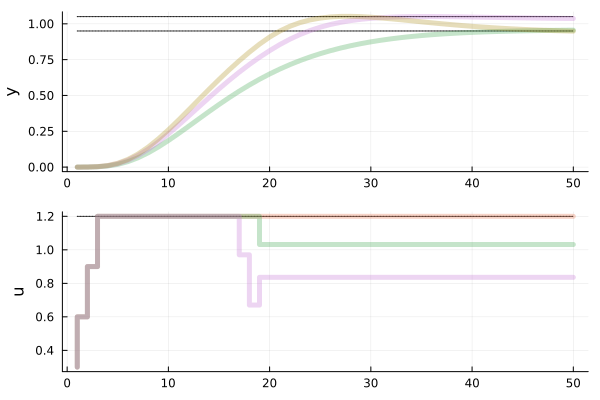

In [11]:
gr()

p1 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p1 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)

for ss = 1:nScen
    if ss == 1 # adding legend
        p1 = plot!(ts,yTraj_m_ol[:,ss],linewidth=5,yaxis="y",linealpha = 0.3)
    else
        p1 = plot!(ts,yTraj_m_ol[:,ss],linewidth=5,linealpha = 0.3,legend=false)
    end
end
    
p1.series_list[1][:label] = "yt"
p1.series_list[2][:label] = ""
p1.series_list[3][:label] = "y1"
p1.series_list[4][:label] = "y2"
p1.series_list[4][:label] = "y3"

p2 = plot(ts,1.2*ones(length(ts)),linestyle = :dot,linecolor = :black)
for ss = 1:nScen
    if ss == 1 # adding legend
        p2 = plot!(ts,uTraj_m_ol[:,ss],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3)
    else
        p2 = plot!(ts,uTraj_m_ol[:,ss],linewidth=5,linetype=:steppre,linealpha = 0.3,legend=false)
    end
end

g1 = plot(p1,p2,layout=(2,1))
display(g1)

# Solving OL-DRTO Multiscenario Problem (decomposed)

using Benders' Decomposition

In [12]:
# Creating function to print the results of the iterations
function print_iteration(k, args...)
    f(x) = Printf.@sprintf("%12.4e",x)
    # lpad: Stringify k and make it n characters (in textwidth) long.  
    # If k is already n characters long, an equal string is returned. Pad with spaces by default.
    println(lpad(k,9), " ",join(f.(args), " "))
    return
end

print_iteration (generic function with 1 method)

## Modeling Subproblem

In [13]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(xInit,uInit,u_fixed,scen)

    # Define our model
    sub = Model(CPLEX.Optimizer)
    set_silent(sub)

    # Set up variables
    # inputs computed by MPCs
    @variable(sub, uMin <= u[1:pD] <= uMax)
    # initial states used by MPC for computing the optimal trajectory
    @variable(sub, x[1:pD, 1:nx])
    # setpoints for the controllers sent to the plant (CL-DRTO degrees of freedom)
    @variable(sub, yMin <= y[1:pD] <= yMax)
    # slacks for controlling setpoint into a zone
    @variable(sub, delta_y_p[1:pD] >= 0)
    @variable(sub, delta_y_m[1:pD] >= 0)

    # Set up objective function
    @objective(sub, Min, pScen*sum(u[kk] + 1e5*(delta_y_p[kk]^2 + delta_y_m[kk]^2) for kk in 1:pD))

    # Model Dynamic for Dynamic RTO
    @constraint(sub, OLDRTO_dyn_model_1, x[1,:] .== A_drto*xInit + B_drto_s[:,scen]*uInit)
    @constraint(sub, OLDRTO_dyn_model[kk=1:(pD - 1)], x[kk + 1,:] .== A_drto*x[kk,:] + B_drto_s[:,scen]*u[kk])
    @constraint(sub, OLDRTO_model_out[kk=1:pD], y[kk] == C_drto'*x[kk,:])

    # fixing input after mD
    @constraint(sub, control_horizon[kk=(mD+1):pD], u[kk] == u[mD])

    # Δu constraints
    @constraint(sub, ΔU_max_0, -ΔUMax <= u[1] - uInit <= ΔUMax)
    @constraint(sub, ΔU[kk=2:mD], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax)

    # ysp in target
    @constraint(sub, target_plus[kk=1:pD], y[kk] + delta_y_p[kk] >= 0.95)
    @constraint(sub, target_minus[kk=1:pD], y[kk] - delta_y_m[kk] <= 1.05)

    # nonanticipativity constraints
    @constraint(sub, nonAnt[kk=1:nDRTO], u[kk] - u_fixed[kk] == 0.0);
    
    # @show model_ms
    
    optimize!(sub)
    flag = termination_status(sub)
    # #primal_status(m)
    
    #calling values of the solved problem
    o = objective_value(sub)
    uArray = value.(u)
    xArray = value.(x)
    yArray = value.(y)
    dpArray = value.(delta_y_p)
    dmArray = value.(delta_y_m)
    
    # all_con = all_constraints(model_ms, AffExpr, MOI.EqualTo{Float64})
    λ = dual.(nonAnt)
    
    return Dict('o' => o, 'f' => flag, 'λ' => λ, 'u' => uArray, 'x' => xArray, 'y' => yArray, 'd' => dpArray, 'c' => dmArray)
end;

In [14]:
## Modeling the master problem  --> checking the problem use> print(master)

# bound
alpha_down = 0.0;

master = Model(CPLEX.Optimizer)
set_silent(master)

@variable(master, 0.0 <= u[1:nDRTO] <= uMax, start = 0.5)
@variable(master, α ≥ alpha_down)

 # Δu constraints
@constraint(master, ΔU_max_0, -ΔUMax <= u[1] - u0 <= ΔUMax)
@constraint(master, ΔU[kk=2:nDRTO], -ΔUMax <= u[kk] - u[kk - 1] <= ΔUMax)

@objective(master, Min, α);

In [15]:
# solving problem with random initial guesses for the solution of the master problem 
# to ensure that the algorithm does not get stuck at initial solution 
for ii in 1:3
    # solve master problem
    if ii == 1
        #u_nonⁱ = [0.1, 0.2, 0.3, 0.4, 0.5]
        u_nonⁱ = [0.1, 0.1, 0.1, 0.1, 0.1]
    elseif ii == 2
        #u_nonⁱ = [0.2, 0.4, 0.6, 0.8, 1.0]
        u_nonⁱ = [0.2, 0.2, 0.2, 0.2, 0.2]
    else
        #u_nonⁱ = [0.15, 0.3, 0.45, 0.6, 0.75]
        u_nonⁱ = [0.3, 0.3, 0.3, 0.3, 0.3]
    end
        
    # print iteration information
    print_iteration(ii,u_nonⁱ[1],u_nonⁱ[2],u_nonⁱ[3],u_nonⁱ[4],u_nonⁱ[5])

    # sensitivity (num scenario, num var)
    lambda_N = [subp(x0,u0,u_nonⁱ,ss)['λ']' for ss in 1:nScen]  
    
    benderscut = @constraint(master, α ≥ sum(sum(lambda_N[ss][jj] for ss in 1:nScen)*(u[jj] - u_nonⁱ[jj]) for jj in 1:nDRTO))
    @info "Adding this bender cut $(benderscut)"
end



        1   1.0000e-01   1.0000e-01   1.0000e-01   1.0000e-01   1.0000e-01
        2   2.0000e-01   2.0000e-01   2.0000e-01   2.0000e-01   2.0000e-01
        3   3.0000e-01   3.0000e-01   3.0000e-01   3.0000e-01   3.0000e-01

[ Info: Adding this bender cut 115146.19988375437 u[1] + 108213.90938805153 u[2] + 100980.6856441946 u[3] + 93510.5448616769 u[4] + 297615.5354221802 u[5] + α >= 71546.68751998576
[ Info: Adding this bender cut 110111.87754936711 u[1] + 103033.20228886046 u[2] + 95709.56795415308 u[3] + 88210.89943395251 u[4] + 277415.33888791536 u[5] + α >= 134896.1772228497


[ Info: Adding this bender cut 105109.73461280247 u[1] + 97888.55722103741 u[2] + 90478.70634504566 u[3] + 82956.00066971697 u[4] + 208797.56964556497 u[5] + α >= 175569.17054825023


In [16]:
println("k  u[1]  u[2]  u[3]  u[4]  u[5]   lowerbound  upperbound  gap")

p3 = plot(legend=false, xlabel="iteration", ylabel="OF value")

# solving problem with benders' decomposition 
for ii in 1:20
    # solve master problem
    optimize!(master)
    
    # lower bound of the original problem
    lb = objective_value(master)
    u_nonⁱ = value.(u)
    #display(u_nonⁱ)
    #display(subp(x0,u0,u_nonⁱ,1)['o'])
    #display(subp(x0,u0,u_nonⁱ,2)['o'])
    #display(subp(x0,u0,u_nonⁱ,3)['o'])
    
    # solve the subproblem to find the upper 
    ub = sum(subp(x0,u0,u_nonⁱ,ss)['o'] for ss in 1:nScen)
    #display(ub)
    
    # compute optimality gap
    gap = abs(ub - lb)/abs(ub)
    
    # print iteration information
    print_iteration(ii,u_nonⁱ[1],u_nonⁱ[2],u_nonⁱ[3],u_nonⁱ[4],u_nonⁱ[5],lb,ub,gap)

    plot!([ii],[lb], marker=:circle,  markercolor = :green)
    plot!([ii],[ub], marker=:square, markercolor = :red)
    
    # check if optimality gap is small enough
    if gap < 1e-5 
        println(" **** solution found ********")
        global uSol = u_nonⁱ
        break
    end
    
    # sensitivity (num scenario, num var)
    lambda_N = [subp(x0,u0,u_nonⁱ,ss)['λ']' for ss in 1:nScen]  
    #display(lambda_N[1][2])
    #display(lambda_N[2][2])
    #display(lambda_N[3][2])
    #display(size(lambda_N))
    
    benderscut = @constraint(master, α ≥ ub + sum(sum(lambda_N[ss][jj] for ss in 1:nScen)*(u[jj] - u_nonⁱ[jj]) for jj in 1:nDRTO))
    #@info "Adding this bender cut $(benderscut)"
end

k  u[1]  u[2]  u[3]  u[4]  u[5]   lowerbound  upperbound  gap
        1   3.0000e-01   0.0000e+00   0.0000e+00   2.7899e-01   5.7899e-01   0.0000e+00   1.2317e+06   1.0000e+00
        2   3.0000e-01   6.0000e-01   9.0000e-01   1.2000e+00   1.2000e+00   8.9393e+05   9.8640e+05   9.3750e-02
        3   3.0000e-01   6.0000e-01   9.0000e-01   1.0837e+00   7.8365e-01   9.8640e+05   1.0219e+06   3.4694e-02
        4   3.0000e-01   6.0000e-01   9.0000e-01   1.2000e+00   1.0478e+00   9.8640e+05   9.9448e+05   8.1200e-03
        5   3.0000e-01   6.0000e-01   9.0000e-01   9.4915e-01   1.1987e+00   9.8640e+05   1.0017e+06   1.5255e-02
        6   3.0000e-01   6.0000e-01   9.0000e-01   1.1979e+00   1.1987e+00   9.8640e+05   9.8660e+05   1.9817e-04
        7   3.0000e-01   6.0000e-01   9.0000e-01   1.2000e+00   1.2000e+00   9.8640e+05   9.8640e+05   3.6763e-08
 **** solution found ********


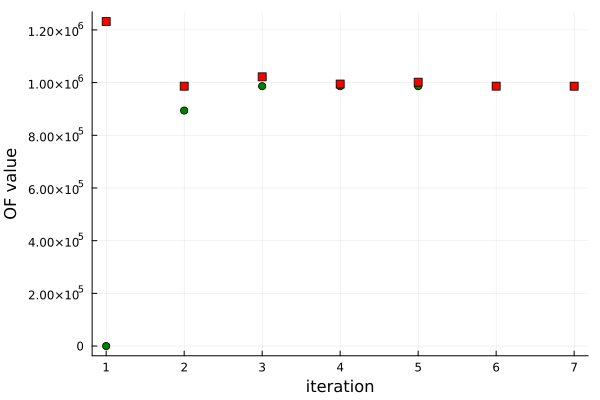

In [17]:
display(p3)

In [18]:
# Get values for plotting
xTraj_d_ol = Array{Float64}(undef,nx,pD,nScen)
uTraj_d_ol = Matrix{Float64}(undef,pD,nScen) 
yTraj_d_ol = Matrix{Float64}(undef,pD,nScen) 

for ss in 1:nScen
    xTraj_d_ol[:,:,ss] .= subp(x0,u0,uSol,ss)['x']'
    yTraj_d_ol[:,ss] = subp(x0,u0,uSol,ss)['y']
    uTraj_d_ol[:,ss] = subp(x0,u0,uSol,ss)['u']
end;

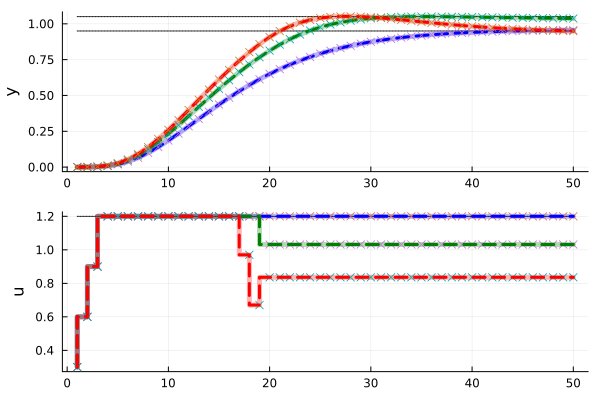

In [19]:
gr()

# limits
p4 = plot(ts,1.05*ones(length(ts)),linestyle = :dot,linecolor = :black)
p4 = plot!(ts,0.95*ones(length(ts)),linestyle = :dot,linecolor = :black)

# scenario 1
p4 = plot!(ts,yTraj_m_ol[:,1],linewidth=5,yaxis="y",linealpha = 0.3,linecolor = :blue)
p4 = plot!(ts,yTraj_d_ol[:,1],linewidth=3,linestyle=:dash,markershape=:xcross,linecolor = :blue)

# scenario 1
p4 = plot!(ts,yTraj_m_ol[:,2],linewidth=5,yaxis="y",linealpha = 0.3,linecolor = :green,legend=false)
p4 = plot!(ts,yTraj_d_ol[:,2],linewidth=3,linestyle=:dash,markershape=:xcross,linecolor = :green,legend=false)

# scenario 1
p4 = plot!(ts,yTraj_m_ol[:,3],linewidth=5,yaxis="y",linealpha = 0.3,linecolor = :red,legend=false)
p4 = plot!(ts,yTraj_d_ol[:,3],linewidth=3,linestyle=:dash,markershape=:xcross,linecolor = :red,legend=false)
    
p4.series_list[1][:label] = "yt"
p4.series_list[2][:label] = ""
p4.series_list[3][:label] = "y_m"
p4.series_list[4][:label] = "y_d"

# limtes
p5 = plot(ts,1.2*ones(length(ts)),linestyle = :dot,linecolor = :black)

# scenario 1
p5 = plot!(ts,uTraj_m_ol[:,1],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :blue)
p5 = plot!(ts,uTraj_d_ol[:,1],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :blue)

# scenario 2
p5 = plot!(ts,uTraj_m_ol[:,2],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :green,legend=false)
p5 = plot!(ts,uTraj_d_ol[:,2],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :green,legend=false)

# scenario 3
p5 = plot!(ts,uTraj_m_ol[:,3],linewidth=5,linetype=:steppre,yaxis="u",linealpha = 0.3,linecolor = :red,legend=false)
p5 = plot!(ts,uTraj_d_ol[:,3],linewidth=3,linetype=:steppre,linestyle=:dash,markershape=:xcross,linecolor = :red,legend=false)

p5.series_list[1][:label] = "ul"
p5.series_list[2][:label] = ""
p5.series_list[3][:label] = "u_m"
p5.series_list[4][:label] = "u_d"

g2 = plot(p4,p5,layout=(2,1))
display(g2)

In [20]:
jldsave("OL_decomp.jld2"; xTraj_m_ol, uTraj_m_ol, yTraj_m_ol, xTraj_d_ol, uTraj_d_ol, yTraj_d_ol)